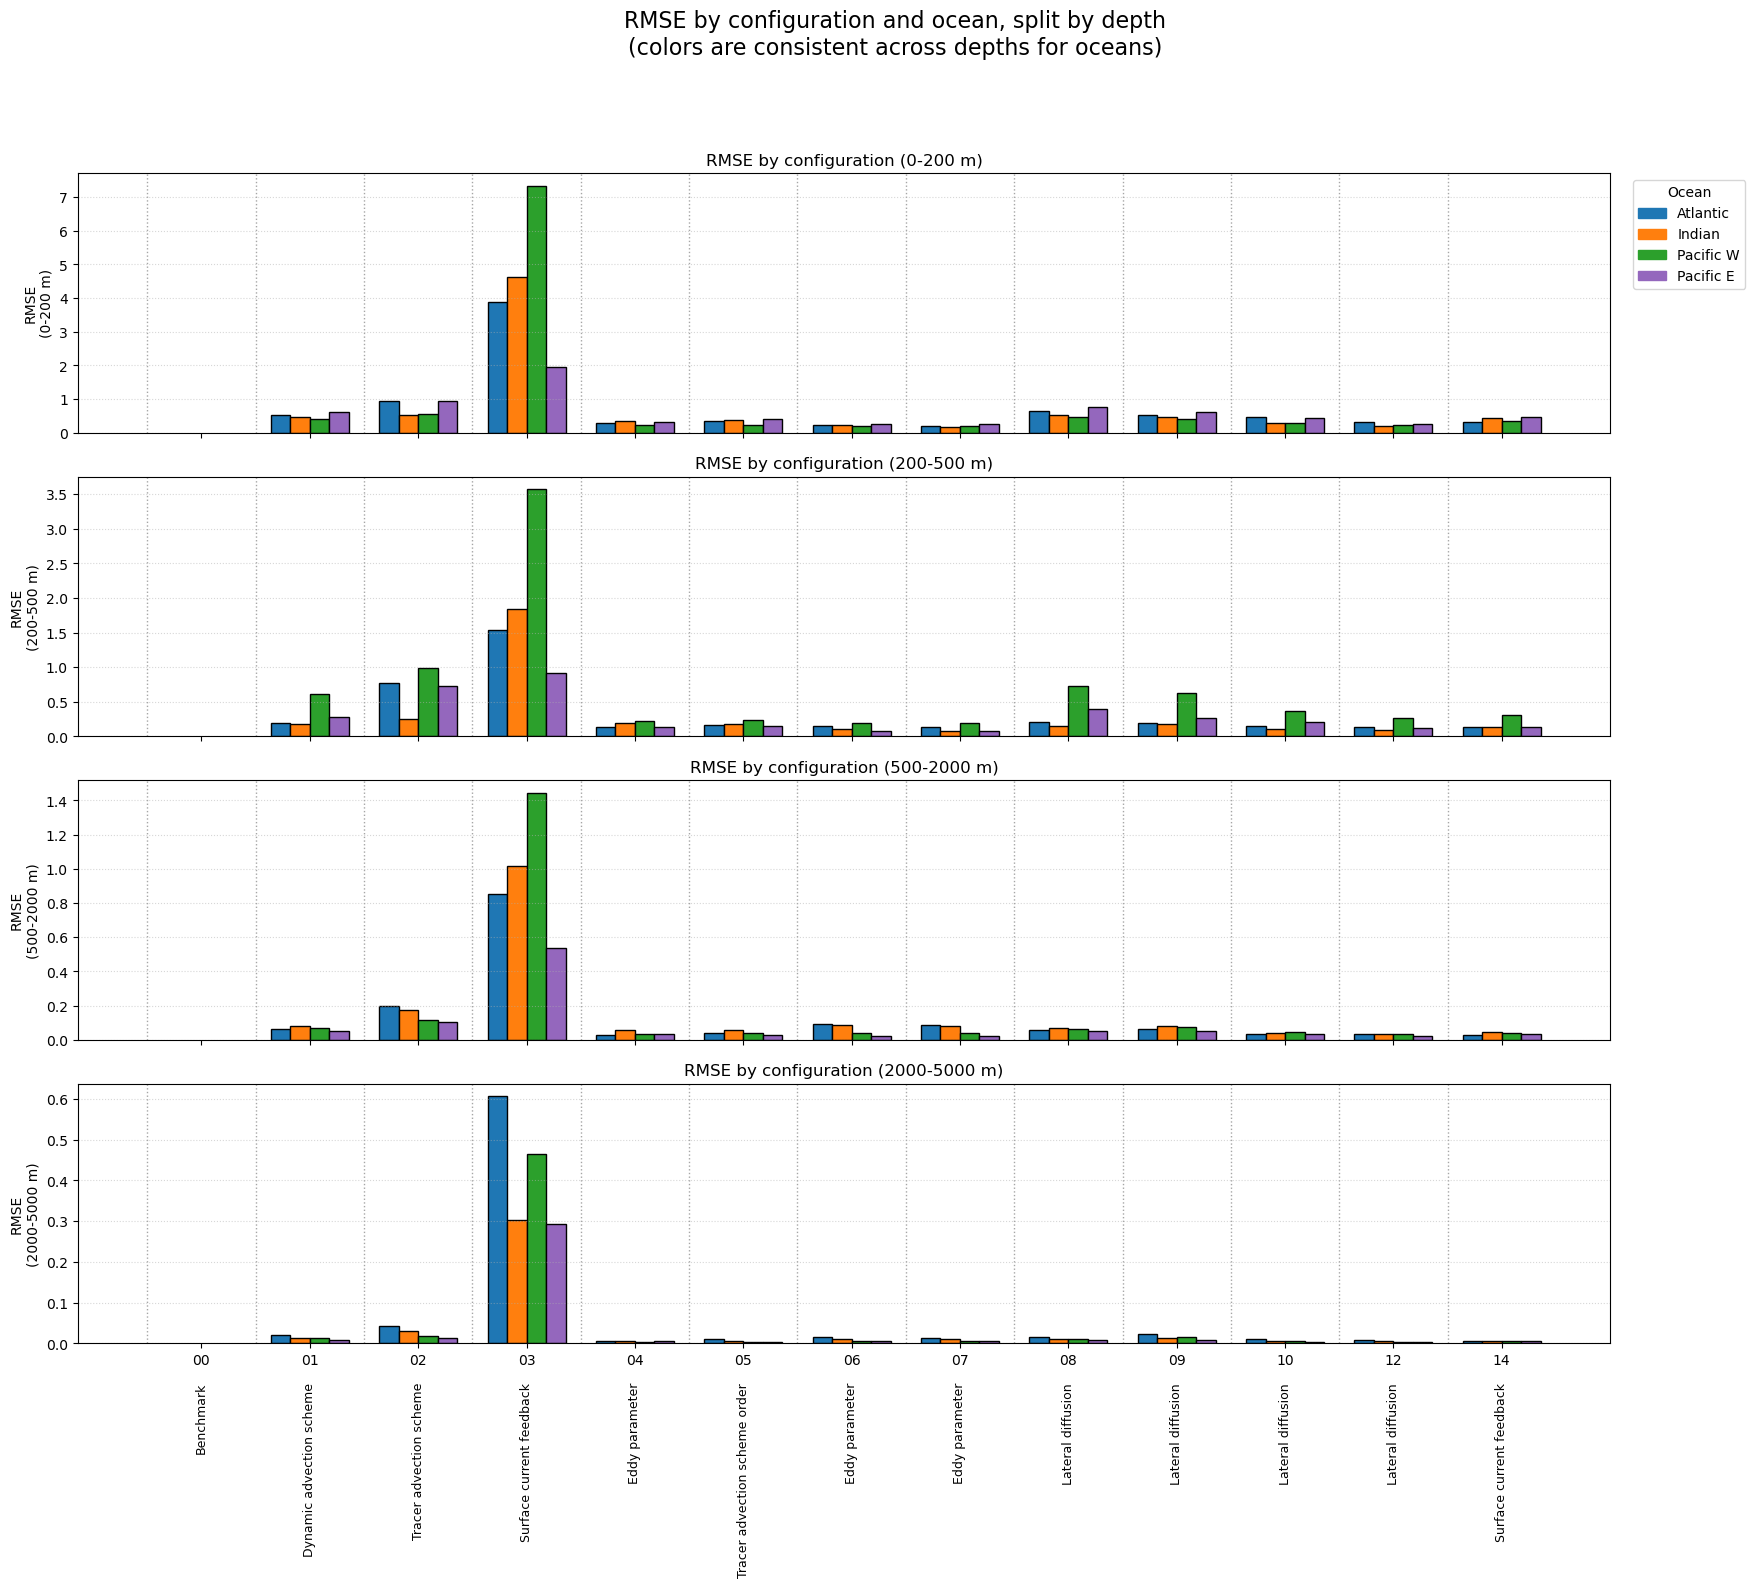

In [18]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Global variable: desired depth intervals to plot (min_depth, max_depth) ---
DESIRED_HEIGHTS = [
    (0, 200),      # "upper"
    (200, 500),    # "middle"
    (500, 2000),   # "deep"
    (2000, 5000),  # "very deep"
]

# --- Setup ---
DATA_DIR = os.path.expanduser("~/NEMOCheck/data/model")
ref = xr.open_dataset(os.path.join(DATA_DIR, "nemo00_1m_201001_202212_Eq.nc")).sel(time_counter=slice("2011-01-01", "2022-12-31"))
ref = ref["to"]

# Ocean domains (lon_min, lon_max) for each ocean
OCEAN_DOMAINS = {
    "Atlantic":  (-60, 20),
    "Indian":    (30, 110),
    "Pacific W": (120, 180),
    "Pacific E": (-180, -70),
}
ocean_names = list(OCEAN_DOMAINS.keys())
ocean_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]
ocean_color_dict = dict(zip(ocean_names, ocean_colors))

cfgs = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "14"]
cfg_descriptions = [
    "Benchmark", "Dynamic advection scheme", "Tracer advection scheme", "Surface current feedback",
    "Eddy parameter", "Tracer advection scheme order", "Eddy parameter", "Eddy parameter",
    "Lateral diffusion", "Lateral diffusion", "Lateral diffusion", "Lateral diffusion", "Surface current feedback"
]

lon = ref["nav_lon_grid_T"]
depth = ref["deptht"]

# Build all (ocean, depth_range) "boxes"
BOXES = []
for min_depth, max_depth in DESIRED_HEIGHTS:
    for ocean in ocean_names:
        lon_min, lon_max = OCEAN_DOMAINS[ocean]
        box_label = f"{ocean} {min_depth}-{max_depth}m"
        BOXES.append( (box_label, ocean, min_depth, max_depth, lon_min, lon_max) )

mean_errors = np.full((len(cfgs), len(BOXES)), np.nan)

for i, cfg in enumerate(cfgs):
    if cfg == "00":
        continue
    ds = xr.open_dataset(os.path.join(DATA_DIR, f"nemo{cfg}_1m_201001_202212_Eq.nc"))
    ds = ds.sel(time_counter=slice("2011-01-01", "2022-12-31"))
    ds = ds["to"]
    error = ref - ds

    for j, (box_label, ocean, min_depth, max_depth, lon_min, lon_max) in enumerate(BOXES):
        lon_mask = (lon >= lon_min) & (lon <= lon_max)
        depth_mask = (depth >= min_depth) & (depth < max_depth)
        masked = error.where(lon_mask)
        masked = masked.sel(deptht=depth[depth_mask])
        rmse = np.sqrt((masked ** 2).mean(skipna=True)).item()
        mean_errors[i, j] = rmse
    ds.close()

# --- Plot: One panel per desired depth interval ---
n_cfg = len(cfgs)
n_oceans = len(ocean_names)
n_heights = len(DESIRED_HEIGHTS)
bar_width = 0.18

fig, axes = plt.subplots(
    nrows=n_heights, ncols=1, figsize=(18, 4*n_heights),
    sharex=True, sharey=False
)

if n_heights == 1:
    axes = [axes]

for hidx, (min_depth, max_depth) in enumerate(DESIRED_HEIGHTS):
    ax = axes[hidx]
    # Find boxes for this height
    boxes_this_height = [i for i, box in enumerate(BOXES) if box[2] == min_depth and box[3] == max_depth]
    for oidx, ocean in enumerate(ocean_names):
        # Get box index for this ocean and height
        box_indices = [i for i in boxes_this_height if BOXES[i][1] == ocean]
        if not box_indices:
            continue
        j = box_indices[0]
        offset = -((n_oceans-1)/2)*bar_width + oidx*bar_width
        heights_to_plot = mean_errors[:, j]
        ax.bar(
            np.arange(n_cfg) + offset,
            heights_to_plot,
            width=bar_width,
            color=ocean_color_dict[ocean],
            label=ocean if hidx==0 else None,
            edgecolor="black"
        )
    ax.set_ylabel(f"RMSE\n({min_depth}-{max_depth} m)")
    ax.set_title(f"RMSE by configuration ({min_depth}-{max_depth} m)")
    for xi in np.arange(n_cfg):
        ax.axvline(x=xi-0.5, color='grey', linestyle=':', linewidth=1, alpha=0.7, zorder=0)
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    ax.set_xticks(np.arange(n_cfg))
    if hidx == n_heights-1:
        ax.set_xticklabels(cfgs, fontsize=10)
        for j, desc in enumerate(cfg_descriptions):
            ax.text(j, ax.get_ylim()[0] - 0.15 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                    desc, rotation=90, fontsize=9, va='top', ha='center')
    else:
        ax.set_xticklabels([])

handles = [Patch(color=ocean_color_dict[o], label=o) for o in ocean_names]
axes[0].legend(handles=handles, title="Ocean", bbox_to_anchor=(1.01, 1), loc='upper left')

fig.suptitle("RMSE by configuration and ocean, split by depth\n(colors are consistent across depths for oceans)", y=0.99, fontsize=16)
plt.tight_layout(rect=[0,0,0.98,0.95])
plt.show()

# Notes

- surface current feedback wasn't the highest error differnce with obs horizontally
- different surface current feedback behaves very differently
- 03 changes even in the deep ocean but more with the Atlantic
- quite a difference in the pacifics
- lateral diffusion, Pacific W, 200-500m